# A notebook for testing our approach in a simple environment

This notebook mostly serves as a sanity check: by trying out our techniques in a simple environment, allowing us to carefully step through the agent's behaviour. 

Fundamentally, it should help us in making sure that everything make sense, before we apply all the machinery to NetHack in all of its complexity.

In [1]:
import tianshou as ts 
from tianshou.utils import TensorboardLogger

import torch
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import nn

import os
import gymnasium as gym

from environments import DictObservation
from networks import GoalNetHackActor, GoalNetHackCritic, DiscreteObsNet
from policies import PPOBasedPolicy
from models import SelfModel, EnvModel
from intrinsic import ICM
from core import GoalCollector, GoalVectorReplayBuffer, GoalOnpolicyTrainer
from utils import EpochStatsPlotter

## Setup

In [2]:
env = DictObservation(gym.make("FrozenLake-v1"))
device = torch.device("cpu")

In [3]:
num_train_envs = 5
num_test_envs = 5

train_envs = ts.env.DummyVectorEnv([lambda: env for _ in range(num_train_envs)])
test_envs = ts.env.DummyVectorEnv([lambda: env for _ in range(num_test_envs)])

In [4]:
obs_net = DiscreteObsNet([16], 10)

actor_net = GoalNetHackActor(obs_net, env.action_space, device=device)
critic_net = GoalNetHackCritic(obs_net, device=device)

In [5]:
train_buf = GoalVectorReplayBuffer(500, num_train_envs)
test_buf = GoalVectorReplayBuffer(1, num_train_envs)

env_model = EnvModel() # this does nothing, for the moment
self_model = SelfModel(obs_net, env.action_space, train_buf, ICM, her_horizon=3, device=device)

In [6]:
# using a single optimizer for actor and critic simplifies the training loop and is more computationally efficient
# BUT gradient updates in one network will influence the gradient updates in the other, and this might create unexpected problems...
combined_params = set(list(actor_net.parameters()) + list(critic_net.parameters()))
optimizer = torch.optim.Adam(combined_params, lr=3e-4)

## Policy

In [7]:
policy = PPOBasedPolicy(
    self_model=self_model,
    env_model=env_model,
    act_net=actor_net, 
    critic_net=critic_net, 
    optim=optimizer,
    action_space=env.action_space,
    observation_space=env.observation_space,
    device=device
)

In [8]:
train_collector = GoalCollector(policy, train_envs, train_buf)
test_collector = GoalCollector(policy, test_envs, test_buf)

In [9]:
num_epochs = 20
num_steps_per_epoch = 1000

step_per_collect = 100
episode_per_test = 5
batch_size = 32

log_path = os.path.join("../logs", "simplenv")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [10]:
trainer = GoalOnpolicyTrainer(
    policy=policy, 
    train_collector=train_collector, 
    test_collector=test_collector,
    repeat_per_collect=1,
    max_epoch=num_epochs,
    step_per_epoch=num_steps_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=episode_per_test,
    batch_size=batch_size,
    logger=logger,
    device=device
)

In [11]:
epoch_stats = []
for epoch_stat in trainer:
    epoch_stats.append(epoch_stat)

Epoch #1: 1001it [00:00, 1944.90it/s, env_step=1000, gradient_step=40, int_rew=0.0000, len=2, n/ep=33, n/st=100, rew=0.0000]                          

Epoch #1: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #2: 1001it [00:00, 3792.96it/s, env_step=2000, gradient_step=80, int_rew=0.0000, len=3, n/ep=30, n/st=100, rew=0.0000]                          

Epoch #2: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #3: 1001it [00:00, 3817.48it/s, env_step=3000, gradient_step=120, int_rew=0.0000, len=2, n/ep=33, n/st=100, rew=0.0000]                          

Epoch #3: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #4: 1001it [00:00, 3814.47it/s, env_step=4000, gradient_step=160, int_rew=0.0000, len=3, n/ep=31, n/st=100, rew=0.0000]                          

Epoch #4: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #5: 1001it [00:00, 3811.72it/s, env_step=5000, gradient_step=200, int_rew=0.0000, len=2, n/ep=38, n/st=100, rew=0.0000]                          

Epoch #5: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #6: 1001it [00:00, 3807.04it/s, env_step=6000, gradient_step=240, int_rew=0.0286, len=4, n/ep=35, n/st=100, rew=0.0286]                          

Epoch #6: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #7: 1001it [00:00, 3816.85it/s, env_step=7000, gradient_step=280, int_rew=0.0000, len=2, n/ep=37, n/st=100, rew=0.0000]                          

Epoch #7: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #8: 1001it [00:00, 3801.50it/s, env_step=8000, gradient_step=320, int_rew=0.0000, len=3, n/ep=37, n/st=100, rew=0.0000]                          

Epoch #8: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #9: 1001it [00:00, 3805.37it/s, env_step=9000, gradient_step=360, int_rew=0.0000, len=2, n/ep=35, n/st=100, rew=0.0000]                          

Epoch #9: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #10: 1001it [00:00, 3240.46it/s, env_step=10000, gradient_step=400, int_rew=0.0000, len=4, n/ep=16, n/st=100, rew=0.0000]                          

Epoch #10: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #11: 1001it [00:00, 3812.58it/s, env_step=11000, gradient_step=440, int_rew=0.0000, len=3, n/ep=33, n/st=100, rew=0.0000]                          


Epoch #11: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


Epoch #12: 1001it [00:00, 3792.52it/s, env_step=12000, gradient_step=480, int_rew=0.0000, len=2, n/ep=30, n/st=100, rew=0.0000]                          

Epoch #12: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #13: 1001it [00:00, 3813.29it/s, env_step=13000, gradient_step=520, int_rew=0.0000, len=4, n/ep=14, n/st=100, rew=0.0000]                          


Epoch #13: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


Epoch #14: 1001it [00:00, 3786.05it/s, env_step=14000, gradient_step=560, int_rew=0.0000, len=3, n/ep=35, n/st=100, rew=0.0000]                          

Epoch #14: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #15: 1001it [00:00, 3740.39it/s, env_step=15000, gradient_step=600, int_rew=0.0000, len=3, n/ep=30, n/st=100, rew=0.0000]                          

Epoch #15: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #16: 1001it [00:00, 3763.15it/s, env_step=16000, gradient_step=640, int_rew=0.0000, len=2, n/ep=33, n/st=100, rew=0.0000]                          

Epoch #16: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #17: 1001it [00:00, 3785.03it/s, env_step=17000, gradient_step=680, int_rew=0.0000, len=4, n/ep=24, n/st=100, rew=0.0000]                          

Epoch #17: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #18: 1001it [00:00, 3799.64it/s, env_step=18000, gradient_step=720, int_rew=0.0000, len=3, n/ep=36, n/st=100, rew=0.0000]                          

Epoch #18: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #19: 1001it [00:00, 3199.98it/s, env_step=19000, gradient_step=760, int_rew=0.0000, len=3, n/ep=25, n/st=100, rew=0.0000]                          

Epoch #19: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0



Epoch #20: 1001it [00:00, 1776.92it/s, env_step=20000, gradient_step=800, int_rew=0.0000, len=5, n/ep=24, n/st=100, rew=0.0000]                          

Epoch #20: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


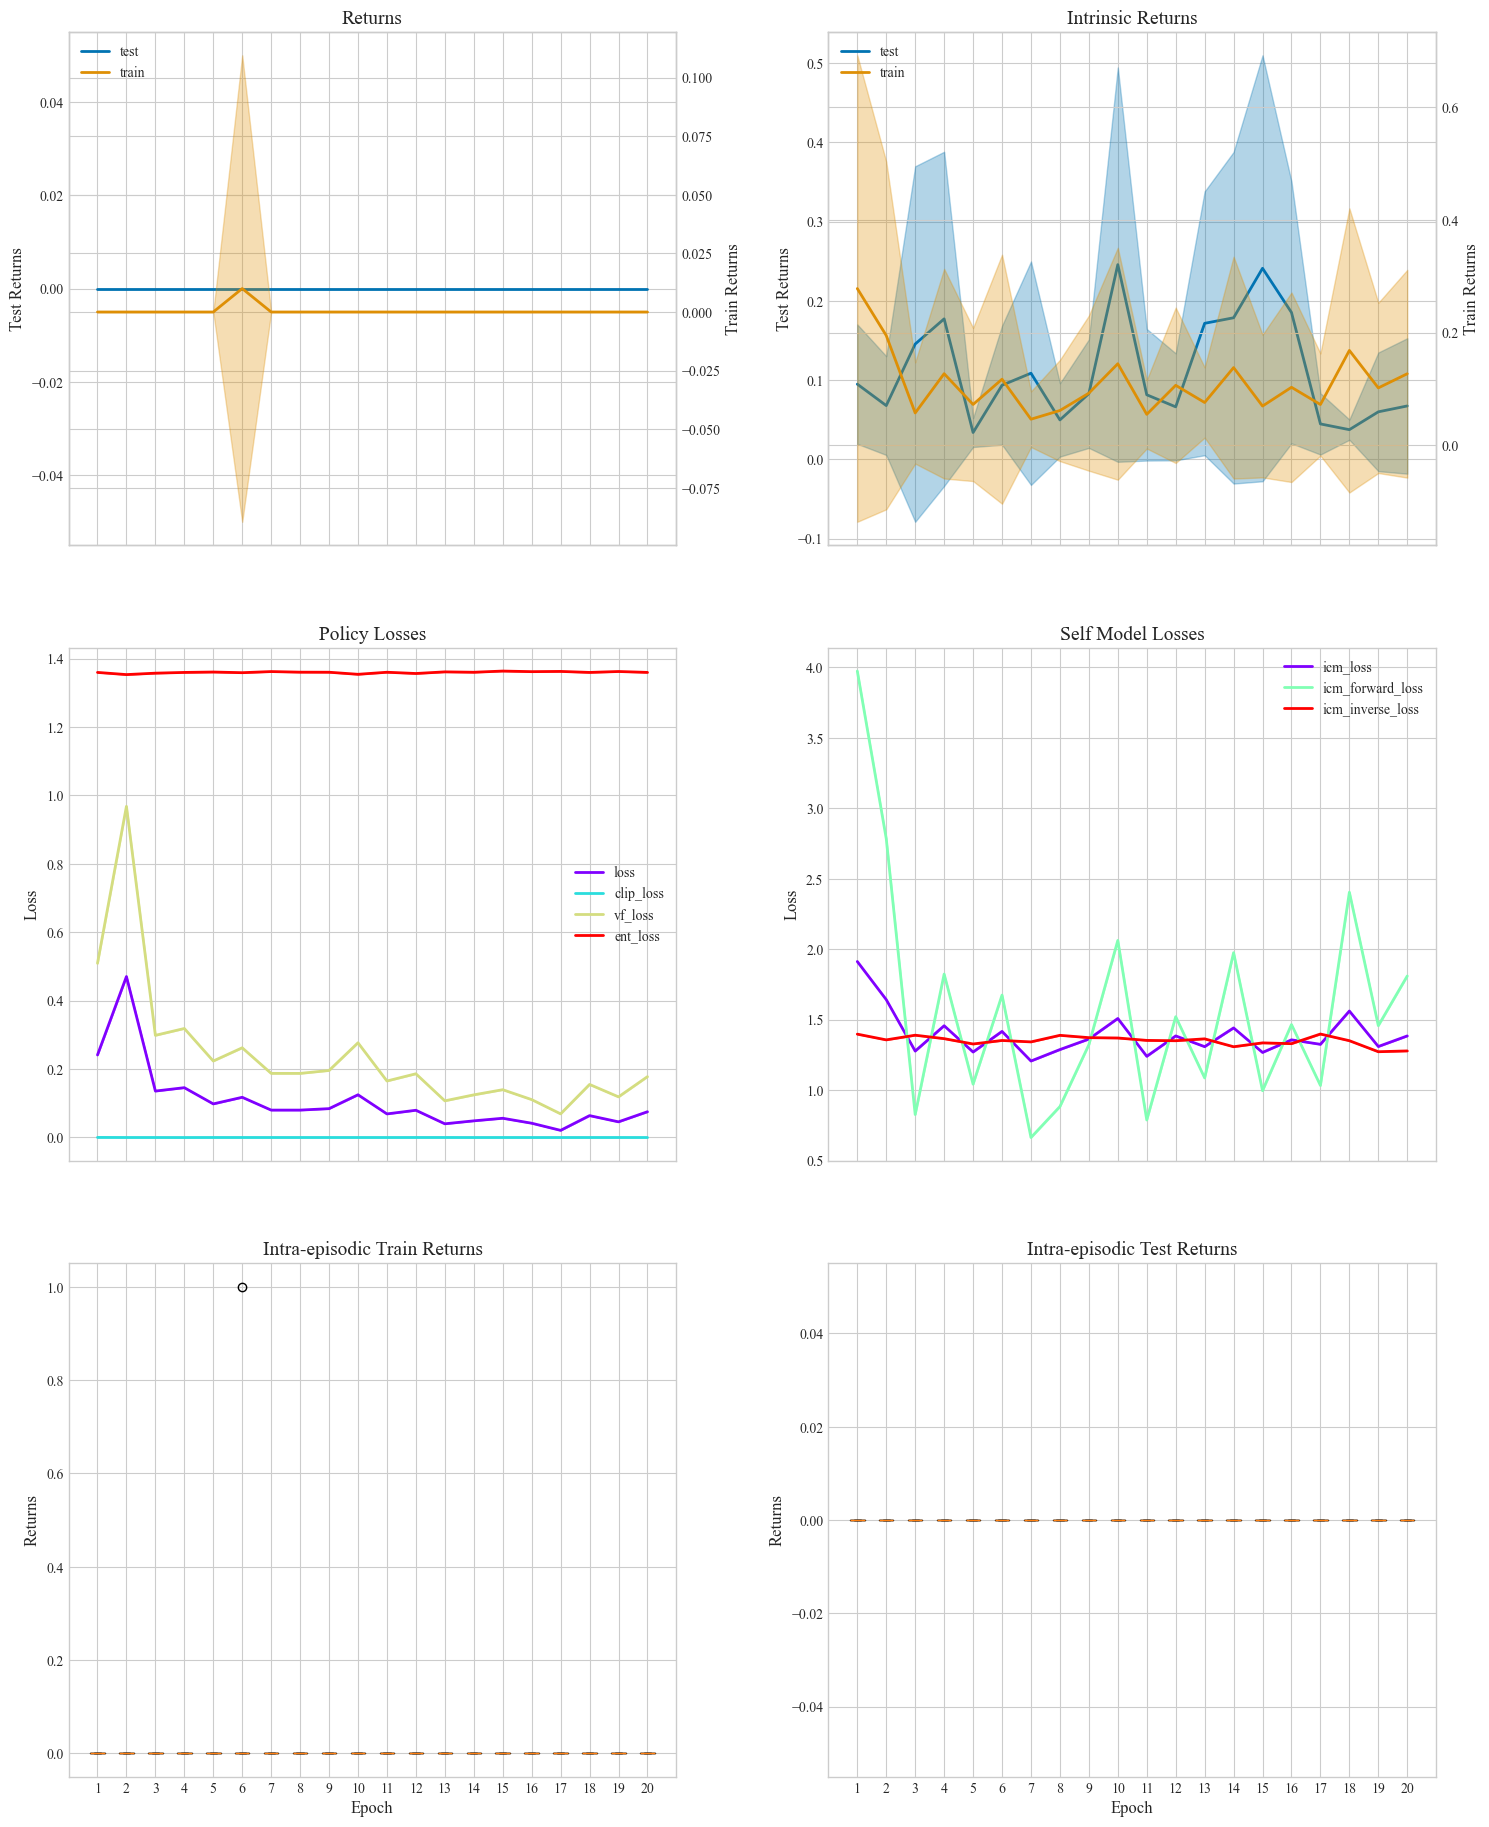

In [12]:
plotter = EpochStatsPlotter(epoch_stats)

# TODO am I logging things right/conveniently?
# TODO look at the TODO in ppo_based and do what it says!
plotter.plot()